In [1]:
import math
import time
import pickle
import pandas as pd
import numpy as np

In [2]:
import torch
import sklearn

In [3]:
from pyqpanda import *

In [4]:
%matplotlib inline

# 1. Prepare Dadaset

In [5]:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [6]:
train_path = './../data/DailyDelhiClimateTrain.csv'
test_path = './../data/DailyDelhiClimateTest.csv'

In [7]:
cols = [1,2,3,4]

train = pd.read_csv(train_path, usecols=cols, engine="python")
test = pd.read_csv(test_path, usecols=cols, engine="python")

In [8]:
print(f'len(train)={len(train)}')
print(f'len(test)={len(test)}')

len(train)=1462
len(test)=114


## 1.1 Outlier Detection

### 1.1.1 outlier detection for train

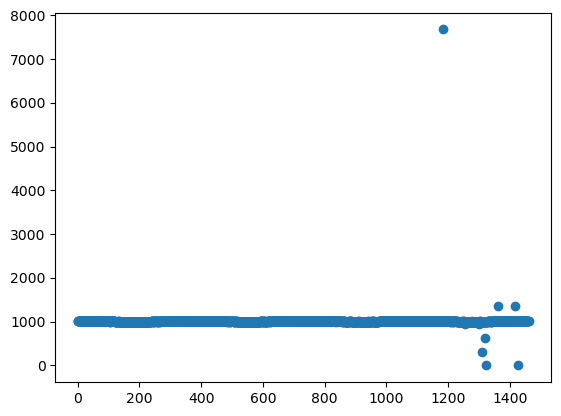

In [9]:
plt.scatter(range(len(train)), train["meanpressure"])

### - remove outliers 

In [10]:
unnormal_num = 0
for i in range(len(train)):
    mp = train.iloc[i][3]
    if mp > 1200 or mp < 950:
        unnormal_num += 1
        train.iloc[i][3] = train.iloc[i + 1][3]
print(f'remove outliers num: {unnormal_num}')

remove outliers num: 9


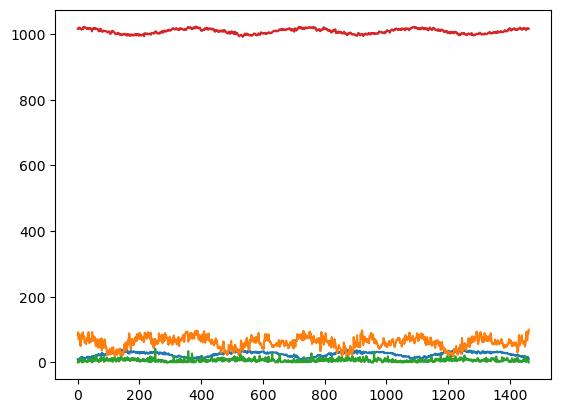

In [11]:
plt.plot(train)

In [12]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1008.247674,7.437992,991.375000,1001.625000,1008.563492,1014.875000,1023.000000


In [13]:
train[0:1]

,meantemp,humidity,wind_speed,meanpressure
0,10.0,84.5,0.0,1015.666667


### 1.1.2 outlier detection for test

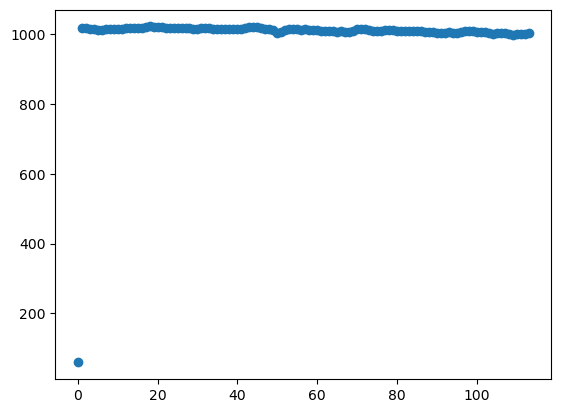

In [14]:
plt.scatter(range(len(test)), test["meanpressure"])

### - remove outliers 

In [15]:
test.iloc[0][3] = test.iloc[1][3]

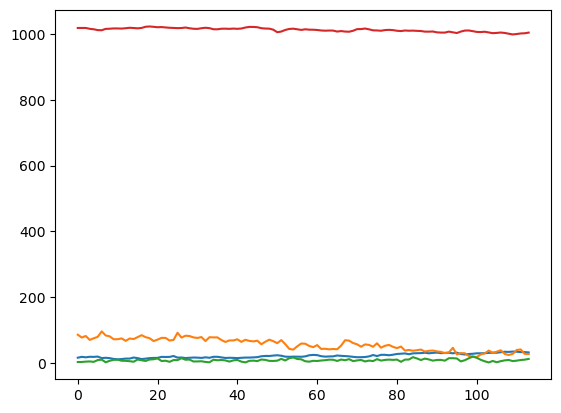

In [16]:
plt.plot(test)

## 1.2 Transfer data to LSTM representation

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

## 1.3 prepare train/test dataset

In [19]:
features_size = 4
window_size = features_size * 3 # features num * time steps
predict_size = features_size # features

In [20]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [21]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

### - data loader

In [22]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
test_data = Data.TensorDataset(X_test, y_test)

In [23]:
print(f'size of train_data: {len(train_data)}')
print(f'size of test_data: {len(test_data)}')

size of train_data: 5832
size of test_data: 440


In [24]:
train_data[0]

(tensor([-0.6262, -0.4504, -0.6498,  1.7473, -0.6323, -0.4327, -0.6428,  1.7523,
         -0.6329, -0.4445, -0.6389,  1.7543]),
 tensor([-0.6293, -0.4814, -0.6469,  1.7508]))

In [25]:
test_data[0]

(tensor([-0.6067, -0.4426, -0.6376,  1.7437, -0.6006, -0.4629, -0.6372,  1.7437,
         -0.6039, -0.4520, -0.6346,  1.7438]),
 tensor([-0.6001, -0.4797, -0.6333,  1.7377]))

# 2. Quantum Enhanced LSTM

## 2.1 initiate quantum environment

In [26]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount = 0, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

In [27]:
# maximum qubits size
ctx = InitQMachine(5)

Init Quantum Machine with qubits:[5] / cbits:[0] Successfully


## 2.2 Quantum Layer

### - Tool Functions

In [28]:
def draw(prog, filename=''):
    dir_path = './images/'
    
    if filename != '':
        draw_qprog(prog, 'pic', filename=f'{dir_path}{filename}')

### 2.2.1 Quantum Layer Base

In [29]:
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter

In [30]:
class QuantumLayerBase(nn.Module):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, ctx = None):
        super(QuantumLayerBase, self).__init__()
        
        self.data = None # need to input during forward
    
        self.input_size = input_size
        self.output_size = output_size # hidden size, not n_qubits
        
        # quantum infos
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.ctx = ctx
        self.qubits = ctx.qubits
        self.machine = ctx.machine
        
        # convert quantum input/output to match classical computation
        self.qin = nn.Linear(self.input_size, self.n_qubits)
        self.qout = nn.Linear(self.n_qubits, self.output_size)
        
    @property
    def circuit(self):
        raise NotImplementedError('Should init circuit')

In [31]:
def measure(self):
    HamiZ = [ PauliOperator({f'Z{i}': 1}) for i in range(len(self.qubits)) ]
    res = [ eval(qop(self.circuit, Hami, self.machine, self.qubits))[0,0] for Hami in HamiZ ]
    
    return Parameter(Tensor(res[:self.n_qubits]))

QuantumLayerBase.measure = measure

In [32]:
def forward(self, inputs):
    y_t = self.qin(Parameter(inputs))
    self.data = y_t[0]
    
    return self.qout(self.measure())

QuantumLayerBase.forward = forward

### 2.2.2 Quantum Layer Design

In [33]:
dropout_lock = True

In [50]:
class QuantumLayer(QuantumLayerBase):
    def __init__(self, input_size, output_size, *, n_qubits, degree = 1, n_layers = 1, ctx = None, dropout_rate = 0):
        super(QuantumLayer, self).__init__(input_size, output_size, 
                                         n_qubits = n_qubits, n_layers = n_layers, ctx = ctx)
        
        self.degree = degree
        self.dropout_rate = dropout_rate
        self.angles = Parameter(torch.rand(n_layers + 1, degree, self.n_qubits))
        
    @property
    def qparameters_size(self):
        return self.angles.flatten().size()[0]
        
    @property
    def circuit(self):
        if self.data == None:
            raise ValueError('Need to feed a input data!')
        
        n = self.n_qubits
        q = self.qubits
        x = self.data
        p = self.angles
        degree = self.degree
        
        # quantum gates - must use small case!
        identity = VariationalQuantumGate_I
        h = VariationalQuantumGate_H
        ry = VariationalQuantumGate_RY
        cz = VariationalQuantumGate_CZ
        u = [
            None,
            VariationalQuantumGate_U1,
            VariationalQuantumGate_U2,
            VariationalQuantumGate_U3
        ]
        
        # init variational quantum circuit
        vqc = VariationalQuantumCircuit()

        # in order to use each qubits => when n_qubits < len(ctx.qubits)
        [ vqc.insert(identity(q[i])) for i in range(len(q)) ]
        
        [ vqc.insert( h(q[i]) ) for i in range(n) ]
        [ vqc.insert( ry(q[i], var(x[i] * torch.pi / 2)) ) for i in range(n) ]
        [ vqc.insert( u[degree](q[i], *[ var(p[0][d][i]) for d in range(degree) ]) ) 
                 for i in range(n) ]
    
        for layer in range(self.n_layers):
            for i in range(n - 1):
                vqc.insert(cz(q[i], q[i + 1]))
            vqc.insert(cz(q[n - 1], q[0]))
            
            [ vqc.insert( u[degree](q[i], *[ var(p[layer + 1][d][i]) for d in range(degree) ]) ) 
                 for i in range(n) ]
            
            if dropout_lock and np.random.rand() < self.dropout_rate:
#                 print('drop layer!')
                break
        
        return vqc

### 2.2.3 Plot Quantum layer

In [51]:
data = Tensor([[0.1, 0.2, 0.3, 0.4, 0.5]])
layer = QuantumLayer(5, 5, n_qubits=5, n_layers=1, degree=3, dropout_rate=0.3, ctx=ctx)
layer.data = data[0]
vqc = layer.circuit
prog = create_empty_qprog()
prog.insert(vqc.feed())

In [52]:
draw_qprog(prog, 'pic', filename=f'pic/entanglement_yes')

'null'

## 2.3 Quantum-LSTM

In [53]:
class QLSTMBase(nn.Module):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx = ctx
        self.dropout_rate = dropout_rate
        
    @property
    def qparameters_size(self):
        num = 0
        for attr in dir(self):
            if attr.endswith('_circuit'):
                num += getattr(self, attr).qparameters_size
        return num

In [54]:
def forward(self, inputs, init_states = None):
    sequence_size, batch_size, _ = inputs.size()
    hidden_sequence = []
    
    if init_states == None:
        h_t, c_t = (
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
        )
    else:
        h_t, c_t = init_states
    
    return hidden_sequence, (h_t, c_t)

QLSTMBase.forward = forward

### 2.3.1 classical Quantum-LSTM

In [55]:
class QLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate=0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # Parameters: angles
        #  => Q * (n + 1) * degree
        
        # gates names:  qubits  layers  degree
        # input gate:     5       2       3
        # forget gate:    5       2       3
        # candidate:      5       2       3
        # output gate:    5       2       3
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        # reshape hidden_seq p/ retornar
        #
        # [tensor([[[0.0444, ...]]] => tensor([[[0.0444, ...]]]
        # 
        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.2 adjusted classical QLSTM

In [56]:
class AdjustedQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(AdjustedQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.3 peephole QLSTM

In [57]:
class PeepholeQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # input gate:     4       2       3
        # forget gate:    5       2       3
        # candidate:      4       1       3
        # output gate:    3       2       2
        
        # input gates
        self.input_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                        n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # forget gates
        self.forget_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(PeepholeQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((c_t[0], x_t), dim = 1)
            
            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.4 Coupled Input and Forget gates QLSTM

In [58]:
class CIFGQLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # coupled IF:     5       2       3
        # candidate:      4       2       3
        # output gate:    3       2       2
        
        # Coupled Input and Forget gate
        self.coupled_IF_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 30
        # candidate for cell state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 2, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 24
        # output gates
        self.output_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 2, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 12
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(CIFGQLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # coupled input and forget gate
            f_t = torch.sigmoid(self.coupled_IF_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + ((1 - f_t) * g_t)
            
            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### 2.3.5 Recurrent Gate Units - QGRU

In [59]:
class QGRU(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx, dropout_rate = 0):
        super().__init__(input_size, hidden_size, ctx = ctx, dropout_rate = dropout_rate)
        
        # gates names:  qubits  layers  degree
        # update gate:     5       1       3
        # candidate:       4       1       3
        # reset gate:      3       1       2
        
        # update gates
        self.update_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 5, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 45
        # candidate for hidden state update
        self.candidate_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                       n_qubits = 4, n_layers = 1, degree = 3, ctx = ctx, dropout_rate = dropout_rate) # 36
        # reset gates
        self.reset_circuit = QuantumLayer(input_size + hidden_size, hidden_size, 
                                         n_qubits = 3, n_layers = 1, degree = 2, ctx = ctx, dropout_rate = dropout_rate) # 18
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QGRU, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)
            
            # update gates
            z_t = torch.sigmoid(self.update_circuit(v_t))
            # reset gates
            r_t = torch.sigmoid(self.reset_circuit(v_t))
        
            v_hat_t = torch.cat(((r_t * h_t)[0], x_t), dim = 1)
            # candidate for hidden state update
            g_t = torch.tanh(self.candidate_circuit(v_hat_t))
            h_t = (z_t * g_t) + (1 - z_t) * h_t 

            hidden_sequence.append(h_t)

        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

### - QLSTMs Map

In [60]:
QLSTMMap = {
    'classical': ('QLSTM', QLSTM),
    'adjusted': ('QLSTM(adjusted)', AdjustedQLSTM),
    'peephole': ('peephole QLSTM', PeepholeQLSTM),
    'CIFG': ('CIFG-QLSTM', CIFGQLSTM),
    'GRU': ('QGRU', QGRU)
}

## 2.4 Stacked QLSTM

In [61]:
from collections import OrderedDict

class StackedQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super().__init__()
        
        label, qlstm = QLSTMMap.get(mode)
        self.qlstms = nn.Sequential(OrderedDict([
            (f'{label} {i + 1}', qlstm(input_size if i == 0 else hidden_size , hidden_size, ctx = ctx, dropout_rate = dropout_rate)) 
                for i in range(num_layers)
        ]))

    def forward(self, inputs, parameters = None):
        outputs = None
        
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
        
        return outputs, parameters

# 3. Quantum Model and Train

In [62]:
class QModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1, ctx = None, mode = 'classical', dropout_rate = 0):
        super(QModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.mode = mode
        
        self.qlstm = StackedQLSTM(input_size, hidden_size, 
                                  num_layers = num_layers, ctx = ctx, mode = mode, dropout_rate = dropout_rate)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(1, x.size(1), self.hidden_size)
        c0 = torch.zeros(1, x.size(1), self.hidden_size)
        
        out, _ = self.qlstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

## 3.1 train QModel

In [63]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50, early_stop = False):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    last_loss = 0.0
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        loss = train_loss / batch_size
        if early_stop and abs(loss - train_loss) < 1e-4:
            break
            
        last_loss = loss
        
        print(f'Epoch {step + 1}/{epoch}: Loss: {loss}')
        losses.append(loss)
    
    return losses

## 3.2 Evaluate Model

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def MAE_naive(actuals, predicteds):
    n = len(actuals)
    err = 0.0
    
    for i in range(1, n):
        err += np.abs(actuals[i] - actuals[i - 1])
    return err / (n - 1)

def calculate_accuarcy(model, X_test, y_test, scaler=test_scaler):
    n = len(X_test)
    
    actuals = []
    predicteds = []
    
    for i in range(0, n, predict_size):
        actual = scaler.inverse_transform(y_test[i:i+1].data)
        actuals.append(np.array(actual[0]))
        predicted = scaler.inverse_transform(model(X_test[i:i+1]).data)
        predicteds.append(np.array(predicted[0]))
    
    actuals = np.array(actuals)
    predicteds = np.array(predicteds)
    
    mae = mean_absolute_error(actuals, predicteds)
    mase = mae / MAE_naive(actuals.flatten(), predicteds.flatten())
    mape = mean_absolute_percentage_error(actuals, predicteds)
    mse = mean_squared_error(actuals, predicteds)
    rmse = mse ** 0.5
    
    return np.array([(1 - mase) * 100, rmse, mse, mae, mape])

## 3.3 Train Model

In [65]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [52]:
# learning rate:
# classical: 0.0035
# adjusted: 0.0028
# peephole: 0.0027
# CIFG: 0.004
# GRU: 0.0035

In [51]:
best_score = 0
best_model = None
count = 1
for dropout_rate in [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05]:
    print('-' * 20)
    print('count:', count)
    print('selected hidden_size: ', hidden_size)
    print('selected num_layers: ', num_layers)
    print('selected dropout_rate: ', dropout_rate)
    count += 1
    dropout_lock = True
    qmodel = QModel(input_size, hidden_size, num_output, 
        num_layers = num_layers, ctx = ctx, mode='adjusted', dropout_rate=dropout_rate)
    optimizer = torch.optim.AdamW(qmodel.parameters(), lr = 0.0028)
    loss_func = nn.MSELoss()

    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 100)
    dropout_lock = False
    score = calculate_accuarcy(qmodel, X_test, y_test).numpy()
    if score > best_score:
        best_score = score
        best_model = qmodel
        best_parameters = {
            'hidden_size': hidden_size,
            'num_layers': num_layers,
            'dropout_rate': dropout_rate
        }
    print()

print("Best score: ", best_score)
print("Best parameters: ", best_parameters)

--------------------
count: 1
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.0001
Epoch 1/100: Loss: 1.0216661393642426
Epoch 2/100: Loss: 1.0137975841760636
Epoch 3/100: Loss: 0.971548992395401
Epoch 4/100: Loss: 0.9717328011989593
Epoch 5/100: Loss: 1.0023423552513122
Epoch 6/100: Loss: 0.9300806492567062
Epoch 7/100: Loss: 0.9424782663583755
Epoch 8/100: Loss: 0.8312322676181794
Epoch 9/100: Loss: 0.7589016646146775
Epoch 10/100: Loss: 0.7621568620204926
Epoch 11/100: Loss: 0.7254494041204452
Epoch 12/100: Loss: 0.5681798845529556
Epoch 13/100: Loss: 0.6120424963533878
Epoch 14/100: Loss: 0.5169133849442005
drop layer!
Epoch 15/100: Loss: 0.5892553977668286
drop layer!
Epoch 16/100: Loss: 0.6041202045977115
Epoch 17/100: Loss: 0.5076295658946037
Epoch 18/100: Loss: 0.5454833447933197
Epoch 19/100: Loss: 0.4833170257508755
Epoch 20/100: Loss: 0.43156511448323726
Epoch 21/100: Loss: 0.4868494924157858
Epoch 22/100: Loss: 0.29305435009300707
Epoch 23/100: L

Epoch 87/100: Loss: 0.0006617793165787589
drop layer!
Epoch 88/100: Loss: 0.0005602589608315611
Epoch 89/100: Loss: 0.0006856113381218165
drop layer!
Epoch 90/100: Loss: 0.0005919070115851354
Epoch 91/100: Loss: 0.000443621331032773
Epoch 92/100: Loss: 0.0005482457727339352
Epoch 93/100: Loss: 0.0005635381672618678
Epoch 94/100: Loss: 0.0004455697469893494
Epoch 95/100: Loss: 0.0008124776795739308
drop layer!
Epoch 96/100: Loss: 0.000503061402196181
Epoch 97/100: Loss: 0.0009079823255888186
Epoch 98/100: Loss: 0.0007367215352132916
Epoch 99/100: Loss: 0.0008718840745132184
Epoch 100/100: Loss: 0.0009616011473553953

--------------------
count: 3
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.0003
Epoch 1/100: Loss: 1.0042223364114762
Epoch 2/100: Loss: 0.9730190485715866
Epoch 3/100: Loss: 0.9195254683494568
Epoch 4/100: Loss: 0.881713119149208
drop layer!
drop layer!
Epoch 5/100: Loss: 0.8563609540462493
Epoch 6/100: Loss: 0.7512375354766846
Epoch 7/100: L

drop layer!
Epoch 62/100: Loss: 0.0005432226023913244
Epoch 63/100: Loss: 0.0003896140249707969
Epoch 64/100: Loss: 0.0007093405598425307
drop layer!
Epoch 65/100: Loss: 0.0003964306902162207
drop layer!
drop layer!
Epoch 66/100: Loss: 0.0005496894134921603
Epoch 67/100: Loss: 0.0003288070623966632
Epoch 68/100: Loss: 0.0004672233160817996
drop layer!
Epoch 69/100: Loss: 0.0003782140496696229
Epoch 70/100: Loss: 0.00038362101768143477
drop layer!
Epoch 71/100: Loss: 0.0003870655056061878
Epoch 72/100: Loss: 0.0007951871699333424
drop layer!
Epoch 73/100: Loss: 0.0004038405391838751
drop layer!
Epoch 74/100: Loss: 0.0004339803797847708
Epoch 75/100: Loss: 0.0005626032587315421
drop layer!
Epoch 76/100: Loss: 0.0005243496110779233
Epoch 77/100: Loss: 0.00038828426904728984
Epoch 78/100: Loss: 0.0005654843367665308
Epoch 79/100: Loss: 0.0003612584858274204
drop layer!
Epoch 80/100: Loss: 0.0005020171775868221
drop layer!
Epoch 81/100: Loss: 0.0006072768061130773
Epoch 82/100: Loss: 0.0004

drop layer!
Epoch 17/100: Loss: 0.34580722600221636
drop layer!
Epoch 18/100: Loss: 0.30033367574214936
Epoch 19/100: Loss: 0.2275803368538618
drop layer!
drop layer!
Epoch 20/100: Loss: 0.20085436664521694
Epoch 21/100: Loss: 0.1616341881453991
Epoch 22/100: Loss: 0.11839962024241686
drop layer!
Epoch 23/100: Loss: 0.12444203179329634
drop layer!
drop layer!
Epoch 24/100: Loss: 0.055441705882549285
drop layer!
Epoch 25/100: Loss: 0.04639630489982664
drop layer!
Epoch 26/100: Loss: 0.02737679483834654
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 27/100: Loss: 0.01828944401931949
Epoch 28/100: Loss: 0.010142967815045267
drop layer!
Epoch 29/100: Loss: 0.0051733029540628195
drop layer!
drop layer!
Epoch 30/100: Loss: 0.007034367592132185
drop layer!
Epoch 31/100: Loss: 0.0039883557765278965
drop layer!
drop layer!
drop layer!
Epoch 32/100: Loss: 0.0019328997215779964
drop layer!
drop layer!
Epoch 33/100: Loss: 0.00168320815791958
drop layer!
drop layer!
Epoch 34/100: Loss: 0.001

drop layer!
drop layer!
Epoch 45/100: Loss: 0.21382634583860635
Epoch 46/100: Loss: 0.1715857160743326
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 47/100: Loss: 0.28955724579282105
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 48/100: Loss: 0.24529543143580668
Epoch 49/100: Loss: 0.22406828501698328
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 50/100: Loss: 0.17001258935779334
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 51/100: Loss: 0.15361080272123218
drop layer!
Epoch 52/100: Loss: 0.14536791368300328
drop layer!
drop layer!
drop layer!
Epoch 53/100: Loss: 0.1328794468427077
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 54/100: Loss: 0.10581718850880861
drop layer!
drop layer!
Epoch 55/100: Loss: 0.21829433212406002
drop layer!
drop layer!
drop layer!
Epoch 56/100: Loss: 0.14749664977425708
drop layer!
drop layer!
drop layer!
Epoch 57/100: Loss: 0.13561358346487395
drop layer!
drop layer!
drop layer!
Ep

drop layer!
Epoch 45/100: Loss: 0.00022449096886703045
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 46/100: Loss: 0.0007452206958987517
drop layer!
drop layer!
Epoch 47/100: Loss: 0.0002626673469421803
drop layer!
drop layer!
Epoch 48/100: Loss: 0.0021823300972300787
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 49/100: Loss: 0.0005237294504695456
drop layer!
drop layer!
drop layer!
Epoch 50/100: Loss: 0.0005354073009129934
drop layer!
drop layer!
drop layer!
Epoch 51/100: Loss: 0.00020972234678993119
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 52/100: Loss: 0.0006969059250877763
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 53/100: Loss: 0.0002853975852303847
drop layer!
drop layer!
drop layer!
Epoch 54/100: Loss: 0.0012350029037406784
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 55/100: Loss: 0.0004711094858066645
drop layer!
drop layer!
Epoch 56

drop layer!
Epoch 27/100: Loss: 0.00056241791244247
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 28/100: Loss: 0.0007130587327992544
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 29/100: Loss: 0.0002939364461781224
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 30/100: Loss: 0.0006472513428889215
drop layer!
drop layer!
drop layer!
Epoch 31/100: Loss: 0.00045821261664968915
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 32/100: Loss: 0.0005854462558545492
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 33/100: Loss: 0.0003863319381707697
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 34/100: Loss: 0.00042590948251017833
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 35/100: Loss: 0.000512

drop layer!
drop layer!
drop layer!
drop layer!
Epoch 97/100: Loss: 0.0004697667451182497
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 98/100: Loss: 0.0005824606862006477
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 99/100: Loss: 0.0005569741104409331
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 100/100: Loss: 0.000888079241849482

--------------------
count: 10
selected hidden_size:  32
selected num_layers:  2
selected dropout_rate:  0.01
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 1/100: Loss: 1.02248694896698
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
d

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 36/100: Loss: 0.01137506695522461
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 37/100: Loss: 0.010599262017058209
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 38/100: Loss: 0.005774995817046147
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 39/100: Loss: 0.004137477927724831
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop laye

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 74/100: Loss: 0.0005953395114602245
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 75/100: Loss: 0.0005354528249881696
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 76/100: Loss: 0.0006589610807168356
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 77/100: Loss: 0.0008531617699190974
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 78/100: Loss: 0.0010218659306701738
drop layer!
drop layer!
drop layer

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 8/100: Loss: 0.8805936962366104
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 9/100: Loss: 0.8527704328298569
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 10/100: Loss: 0.79094043970108

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 29/100: Loss: 0.3572968420339748
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 30/100: Loss: 0.24810326445731334
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 31/100: Loss: 0.24641199813922868
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 32/100: Loss: 0.24732932655315382
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
d

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 53/100: Loss: 0.008781129494309425
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 54/100: Loss: 0.00784599059370521
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop la

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 75/100: Loss: 0.0007008965993009042
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 76/100: Loss: 0.0007280222276676796
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 77/100: Loss: 0.0013463083319948054
drop layer!
drop layer!
drop layer!
drop layer

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 98/100: Loss: 0.0010042740083008538
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 99/100: Loss: 0.0016043089064623928
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 100/100: Loss: 0.00078

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 14/100: Loss: 0.25500400736927986
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!


drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 29/100: Loss: 0.0032901965078053763
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 30/100: Loss: 0.

drop layer!
Epoch 44/100: Loss: 0.001052292521490017
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 45/100: Loss: 0.000675838602182921
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 46/100: Loss: 0.0011053210757381749
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!


drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 60/100: Loss: 0.0015174849841969261
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 61/100: Loss: 0.0008942836240748875
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 75/100: Loss: 0.0014106069244007812
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 76/100: Loss: 0.0006230138220416848
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 90/100: Loss: 0.0010141285296413117
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 91/100: Loss: 0.000721832337876549
drop layer!
drop layer!
drop layer!
drop layer!
drop 

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 3/100: Loss: 0.995895317196846
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 4/100: Lo

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 13/100: Loss: 0.6969338029623031
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
d

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 22/100: Loss: 0.43330945894122125
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!


drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 32/100: Loss: 0.2786486838012934
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 33/100:

drop layer!
drop layer!
drop layer!
Epoch 41/100: Loss: 0.21442149858921766
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 42/100: Loss: 0.22605061884969474
drop layer!
drop layer!
drop layer!
drop lay

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 50/100: Loss: 0.08710548519156873
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 51/100: Loss: 0.11610399126075208
drop layer!
drop layer!
drop lay

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 60/100: Loss: 0.018149035316309892
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 69/100: Loss: 0.004712441528681666
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 78/100: Loss: 0.0022285135710262693
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer

drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 88/100: Loss: 0.00406274564229534
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!


drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
Epoch 98/100: Loss: 0.003568858611106407
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!
drop layer!

In [52]:
best_score

array(0.98562235, dtype=float32)

In [66]:
dropout_lock = True
qmodel = QModel(input_size, hidden_size, num_output, 
                num_layers = num_layers, ctx = ctx, mode='adjusted', dropout_rate = 0.003)
optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.0028)
loss_func = nn.MSELoss()

start = time.time()
losses = train_model(qmodel, train_data, batch_size=20,          
               loss_func = loss_func, optimizer = optimizer, epoch = 200, early_stop=True)
end = time.time()

print(f'time costs: {end - start}')

Epoch 1/200: Loss: 0.9805962771177292
Epoch 2/200: Loss: 1.0132244497537612
Epoch 3/200: Loss: 0.9651468902826309
Epoch 4/200: Loss: 0.9424967646598816
Epoch 5/200: Loss: 0.933097967505455
Epoch 6/200: Loss: 0.9103169232606888
Epoch 7/200: Loss: 0.8438472330570221
Epoch 8/200: Loss: 0.7556495815515518
Epoch 9/200: Loss: 0.6609310567378998
Epoch 10/200: Loss: 0.5976217746734619
Epoch 11/200: Loss: 0.5995217103511095
Epoch 12/200: Loss: 0.5090088486671448
Epoch 13/200: Loss: 0.5088945962488651
Epoch 14/200: Loss: 0.3927904568612576
Epoch 15/200: Loss: 0.5399130761623383
Epoch 16/200: Loss: 0.4815056808292866
Epoch 17/200: Loss: 0.509002635255456
Epoch 18/200: Loss: 0.40411144904792307
Epoch 19/200: Loss: 0.33233354315161706
Epoch 20/200: Loss: 0.3630134366452694
Epoch 21/200: Loss: 0.2681371260434389
Epoch 22/200: Loss: 0.14769119620323182
Epoch 23/200: Loss: 0.23460151904728263
Epoch 24/200: Loss: 0.16757701146416365
Epoch 25/200: Loss: 0.10801239229622298
Epoch 26/200: Loss: 0.12324013

Epoch 197/200: Loss: 0.0009246638868717127
Epoch 198/200: Loss: 0.0006810829800087959
Epoch 199/200: Loss: 0.0005894114927286864
Epoch 200/200: Loss: 0.0007955357676109997
time costs: 1916.4767971038818


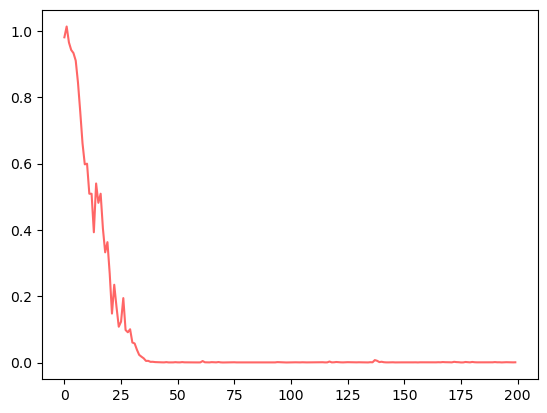

In [67]:
import matplotlib.pyplot as plt

plt.plot(losses, color="#FF6666")

In [68]:
dropout_lock = False
calculate_accuarcy(qmodel, X_test, y_test)

array([ 96.81557598,  20.46051727, 418.63276695,  16.50625549,
         1.12962894])

In [57]:
# array([ 98.33979618,  10.87362236, 118.23566333,   8.60555886,
#          0.60624577])

### - save the model

In [113]:
with open('loss/layer/loss5.pkl', 'wb') as pkl_file:
    pickle.dump(losses, pkl_file)

In [114]:
average_accuracy = np.mean([
    0.9844, 0.9834, 0.9828, 0.9828, 0.9829
])
average_accuracy

0.9832600000000001

### - describe trained model

In [381]:
qmodel

QModel(
  (qlstm): StackedQLSTM(
    (qlstms): Sequential(
      (QGRU 1): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=4, bias=True)
          (qout): Linear(in_features=4, out_features=32, bias=True)
        )
        (reset_circuit): QuantumLayer(
          (qin): Linear(in_features=44, out_features=3, bias=True)
          (qout): Linear(in_features=3, out_features=32, bias=True)
        )
      )
      (QGRU 2): QGRU(
        (update_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=5, bias=True)
          (qout): Linear(in_features=5, out_features=32, bias=True)
        )
        (candidate_circuit): QuantumLayer(
          (qin): Linear(in_features=64, out_features=4, bias=True)
          (qout): Linear(in_features=

In [379]:
trainable = 0
for p in qmodel.parameters():
    if p.requires_grad:
        trainable += p.numel()
print(f'total parameters: {trainable}')

qlstm = QLSTMMap.get(qmodel.mode)[1]
print(f'quantum paramers: {qlstm(1, 1, ctx = ctx).qparameters_size}')

total parameters: 2544
quantum paramers: 66


### - Save the Model

In [53]:
# save the model
torch.save(best_model.state_dict(), "model/layer_adjusted.pt")